In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-2/submission.csv
/kaggle/input/covid19-global-forecasting-week-2/test.csv
/kaggle/input/covid19-global-forecasting-week-2/train.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/train.csv')

## Exploration

In [3]:
display(train_df.head())
display(train_df.info())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19404 entries, 0 to 19403
Data columns (total 6 columns):
Id                19404 non-null int64
Province_State    8250 non-null object
Country_Region    19404 non-null object
Date              19404 non-null object
ConfirmedCases    19404 non-null float64
Fatalities        19404 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 909.7+ KB


None

In [4]:
print('We have', len(train_df.Country_Region.unique()), 'countries/regions in the dataset.')
print('We have', len(train_df.Province_State.unique()), 'provinces/states in the dataset.')

We have 173 countries/regions in the dataset.
We have 126 provinces/states in the dataset.


In [5]:
num_fatalities = train_df.loc[train_df['Date'] == train_df['Date'].max()]['Fatalities'].sum()
print('Between {} and {} there are {} fatalities.'.format(train_df['Date'].min(), train_df['Date'].max(), int(num_fatalities)))

Between 2020-01-22 and 2020-03-27 there are 27192 fatalities.


In [6]:
cz_sick = int(train_df.loc[(train_df['Country_Region'] == 'Czechia') & (train_df['Date'] == train_df['Date'].max())]['ConfirmedCases'].values[0])
cz_fatalities = int(train_df.loc[(train_df['Country_Region'] == 'Czechia') & (train_df['Date'] == train_df['Date'].max())]['Fatalities'].values[0])
print('In Czech Republic there are {} confirmed cases and {} fatalities.'.format(cz_sick, cz_fatalities))

In Czech Republic there are 2279 confirmed cases and 9 fatalities.


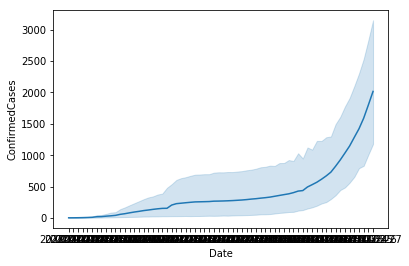

In [18]:
timetrend_sick = sns.lineplot(train_df['Date'], train_df['ConfirmedCases'])

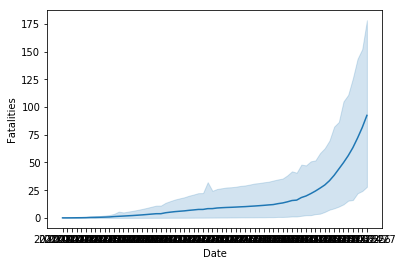

In [19]:
timetrend_deceased = sns.lineplot(train_df['Date'], train_df['Fatalities'])

## Transformation, Pre-processing

In [15]:
train_df['UniqueRegion'] = np.where(train_df['Province_State'].isna(), train_df['Country_Region'], train_df['Country_Region'] + ' - ' + train_df['Province_State'])
train_df.loc[train_df['UniqueRegion'] == 'Afghanistan']

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,UniqueRegion,SickPerDay
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,Afghanistan,0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,Afghanistan,0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,Afghanistan,0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,Afghanistan,0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,Afghanistan,0
...,...,...,...,...,...,...,...,...
61,62,NaN,Afghanistan,2020-03-23,40.0,1.0,Afghanistan,0
62,63,NaN,Afghanistan,2020-03-24,74.0,1.0,Afghanistan,0
63,64,NaN,Afghanistan,2020-03-25,84.0,2.0,Afghanistan,0
64,65,NaN,Afghanistan,2020-03-26,94.0,4.0,Afghanistan,0


In [17]:
# Calculate sick per day

countries = train_df['UniqueRegion'].unique()
train_df['SickPerDay'] = 0

baseline_length = len(train_df.loc[train_df['UniqueRegion'] == 'Afghanistan']) # Country chosen arbitrarily

for country in countries:
    len_country = len(train_df.loc[train_df['UniqueRegion'] == country])
    len_diffs = len(train_df.loc[train_df['UniqueRegion'] == country]['ConfirmedCases'].diff())
    if len_country > baseline_length or len_diffs > baseline_length:
        raise NameError('Too many rows for country {}'.format(country))
    train_df['SickPerDay'].loc[(train_df['UniqueRegion'] == country)] = train_df.loc[train_df['UniqueRegion'] == country]['ConfirmedCases'].diff()
    

train_df['SickPerDay'] = train_df['SickPerDay'].fillna(0)
display(train_df.loc[train_df['UniqueRegion'] == 'Czechia'].tail())
display(train_df.info())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,UniqueRegion,SickPerDay
6001,9062,NaN,Czechia,2020-03-23,1236.0,1.0,Czechia,116.0
6002,9063,NaN,Czechia,2020-03-24,1394.0,3.0,Czechia,158.0
6003,9064,NaN,Czechia,2020-03-25,1654.0,6.0,Czechia,260.0
6004,9065,NaN,Czechia,2020-03-26,1925.0,9.0,Czechia,271.0
6005,9066,NaN,Czechia,2020-03-27,2279.0,9.0,Czechia,354.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19404 entries, 0 to 19403
Data columns (total 8 columns):
Id                19404 non-null int64
Province_State    8250 non-null object
Country_Region    19404 non-null object
Date              19404 non-null object
ConfirmedCases    19404 non-null float64
Fatalities        19404 non-null float64
UniqueRegion      19404 non-null object
SickPerDay        19404 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.2+ MB


None

In [ ]:
# Draw timetrend for ten most affected countries
# Draw timetrend for ten least affected countries

# Span from first sick to first deceased
# Span from first sick to first 100 sick

# Mortality rate per country

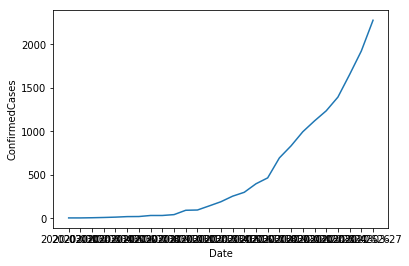

In [20]:
sns.lineplot(train_df.loc[(train_df['UniqueRegion'] == 'Czechia') & (train_df['ConfirmedCases'] > 0)]['Date'], train_df.loc[(train_df['UniqueRegion'] == 'Czechia')& (train_df['ConfirmedCases'] > 0)]['ConfirmedCases'])

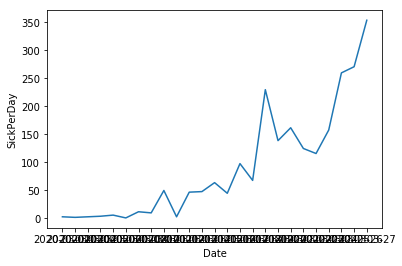

In [21]:
sns.lineplot(x=train_df.loc[(train_df['UniqueRegion'] == 'Czechia') & (train_df['SickPerDay'] > 0)]['Date'],
             y=train_df.loc[(train_df['UniqueRegion'] == 'Czechia')& (train_df['SickPerDay'] > 0)]['SickPerDay'])

In [22]:
top10_most_cases = train_df.loc[train_df['Date'] == train_df['Date'].max()][['UniqueRegion','ConfirmedCases']].sort_values(by='ConfirmedCases', ascending=False).head(10)
top10_most_deceased = train_df.loc[train_df['Date'] == train_df['Date'].max()][['UniqueRegion','Fatalities']].sort_values(by='Fatalities', ascending=False).head(10)
top10_most_sick_per_day = train_df.loc[train_df['Date'] == train_df['Date'].max()][['UniqueRegion','SickPerDay']].sort_values(by='SickPerDay', ascending=False).head(10)

In [23]:
top10_most_cases_df = train_df.loc[train_df['UniqueRegion'].isin(top10_most_cases['UniqueRegion'].values)]

In [24]:
# Transform the dataframe to show each country in a different column

main_df = pd.DataFrame()

for i, top10_country in enumerate (top10_most_cases_df['UniqueRegion'].unique()):
    if i == 0:
        main_df = top10_most_cases_df.loc[top10_most_cases_df['UniqueRegion'] == top10_country][['Date', 'ConfirmedCases']].sort_values(by='Date')
        main_df = main_df.rename({'ConfirmedCases': top10_country}, axis='columns')

    else:
        temp_df = top10_most_cases_df.loc[top10_most_cases_df['UniqueRegion'] == top10_country][['Date', 'ConfirmedCases']]
        temp_df = temp_df.rename({'ConfirmedCases': top10_country}, axis='columns')
        main_df = pd.merge(main_df, temp_df, on=['Date'])

main_df = main_df.set_index('Date')
main_df.head()

,China - Hubei,France,Germany,Iran,Italy,"Korea, South",Spain,Switzerland,US - New York,United Kingdom
Date,,,,,,,,,,
2020-01-22,444.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-23,444.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-24,549.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-25,761.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-26,1058.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


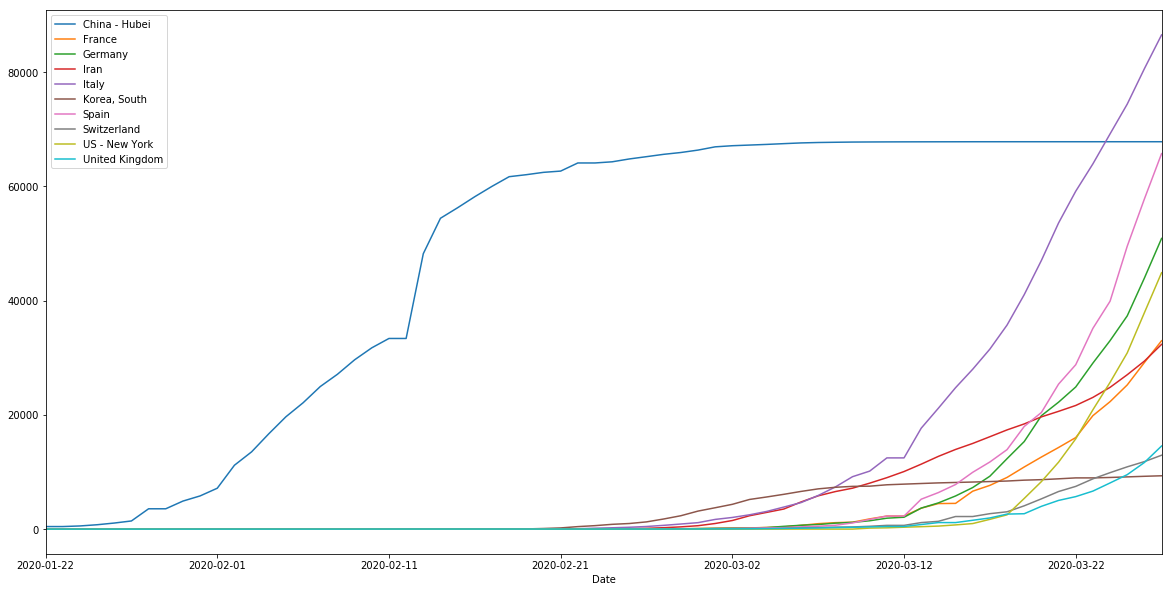

In [25]:
main_df.plot(figsize=(20,10))

In [ ]:
# Build an LSTM first for one country only (Czechia)
# Then expand into all countries
# Figure out how to do predictions on the test set
# Submit predictions
# Expand on the model, add more features, external datasets etc.

In [34]:
# Transform main data into a horizontal dataframe

def transform_horizontally(input_df, value_column):

    horizontal_df = pd.DataFrame()

    for i, uniqueRegion in enumerate (input_df['UniqueRegion'].unique()):
        if i == 0:
            horizontal_df = input_df.loc[input_df['UniqueRegion'] == uniqueRegion][['Date', value_column]].sort_values(by='Date')
            horizontal_df = horizontal_df.rename({value_column: uniqueRegion}, axis='columns')

        else:
            temp_df = input_df.loc[train_df['UniqueRegion'] == uniqueRegion][['Date', value_column]]
            temp_df = temp_df.rename({value_column: uniqueRegion}, axis='columns')
            horizontal_df = pd.merge(horizontal_df, temp_df, on=['Date'])
            
    return horizontal_df

In [35]:
confirmed_horizontal_df = transform_horizontally(train_df, 'ConfirmedCases')
fatalities_horizontal_df = transform_horizontally(train_df, 'Fatalities')


display(confirmed_horizontal_df.head())
display(confirmed_horizontal_df.shape)

display(fatalities_horizontal_df.head())
display(fatalities_horizontal_df.shape)

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia - Australian Capital Territory,...,United Kingdom - Gibraltar,United Kingdom - Isle of Man,United Kingdom - Montserrat,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


(66, 295)